# GeoPick: Centroid and uncertainty calculation
November 2023

In [1]:
import geopandas as gpd
import pandas as pd
import shapely
import matplotlib.pyplot as plt
import geopick as gp
import geopick_plot as gpp
import ipywidgets as widgets
from IPython.display import display, Markdown
import folium
import warnings
import pathlib

warnings.filterwarnings('ignore')
random_seed = 42

## Load location

In [2]:
# Create a Textarea widget
textarea_input = widgets.Textarea(
    value='',
    placeholder='Paste your text here',
    # description='WKT:',
    disabled=False,
    layout={'width': '1095px', 'height': '200px'}  # Set width and height
)
def clear_wkt_textarea(b):
    # Clear the Textarea by setting its value to an empty string    
    textarea_input.value = ""

button = widgets.Button(description="Clear WKT")
button.on_click(clear_wkt_textarea)
box = widgets.VBox([button, textarea_input], layout=widgets.Layout(align_items='flex-start'))

f_wkt = "../data/capdecreus.wkt"
location_wkt = textarea_input.value
location_wkt = pathlib.Path(f_wkt).read_text()
textarea_input.value = location_wkt
display(box)


In [3]:
def extract_wkt(items):  
  wkt = None
  for item in items:
    if item.startswith("POINT") or item.startswith("LINESTRING") or \
      item.startswith("MULTILINESTRING") or item.startswith("POLYGON") or \
      item.startswith("MULTIPOLYGON"):
        wkt = item
        break  # Stop searching once a match is found
  return wkt
items = textarea_input.value.split("\t")
location_wkt = extract_wkt(items)

if location_wkt.startswith("POINT"):
  if(len(items) == 1):
    print("POINT geometry, uncertainty not specified.\n")
  else:
    print("POINT geometry.\n")
    print("Latitude:", items[0], ", Longitude:", items[1], ", Uncertainty:", items[3])
  class StopExecution(Exception):
   def _render_traceback_(self):
    return []
  raise StopExecution

location_wgs84 = gpd.GeoSeries(shapely.wkt.loads(location_wkt))
location_wgs84.crs = "EPSG:4326"

# Map
latitude = location_wgs84.centroid.get_coordinates()["y"][0]
longitude = location_wgs84.centroid.get_coordinates()["x"][0]
fcol = lambda x: {
    'fillColor': "blue" if x["properties"]["is_marine"] == "True" else "green",
    'color': "blue" if x["properties"]["is_marine"] == "True" else "green"
}

m = folium.Map(location = [latitude, longitude], zoom_start = 15)
folium.GeoJson(location_wgs84).add_to(m)
m

## Project to AEQD

In [4]:
# Get AEQD projection focused on WGS84 centroid
centroid_wgs84 = location_wgs84.centroid
proj_aeqd = gp.get_proj_aeqd(centroid_wgs84)

# Project location to AEQD projection
location_aeqd = location_wgs84.to_crs(proj_aeqd)
centroid_aeqd = centroid_wgs84.to_crs(proj_aeqd)

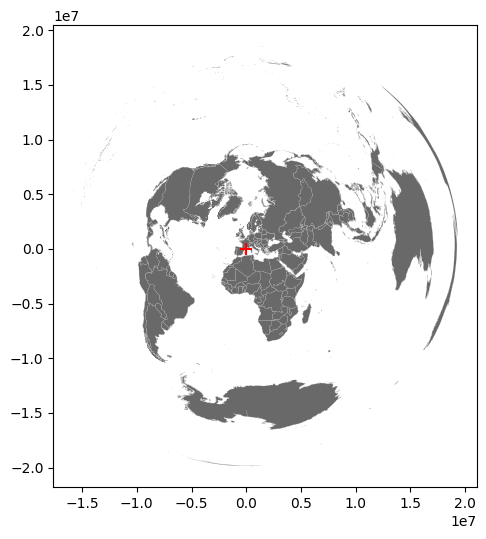

In [5]:
gpp.plot_earth_aeqd(proj_aeqd)

## Simplify geometry

In [6]:
location_aeqd = gp.simplify_geometry(location_aeqd)

## Calculate centroid

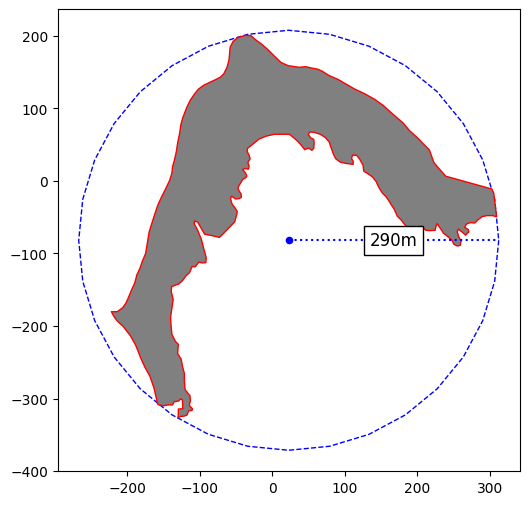

In [9]:
# Calculate SEC and its centroid
sec_aeqd = gp.get_sec(location_aeqd)
centroid_aeqd = gp.get_sec_centroid(sec_aeqd)
centroid_aeqd.crs = proj_aeqd

# Plot
radius = gp.get_radius_line(centroid_aeqd, sec_aeqd)
radius_line = radius[0]
uncertainty = radius[1]

gpp.plot_geopick(sec_aeqd, location_aeqd, centroid_aeqd, radius_line, uncertainty, None, None, None, None, None, None, None, None)


## Correct center

In [10]:
centroid_inside = gp.is_centroid_inside(centroid_aeqd, location_aeqd)

### Centroid candidates

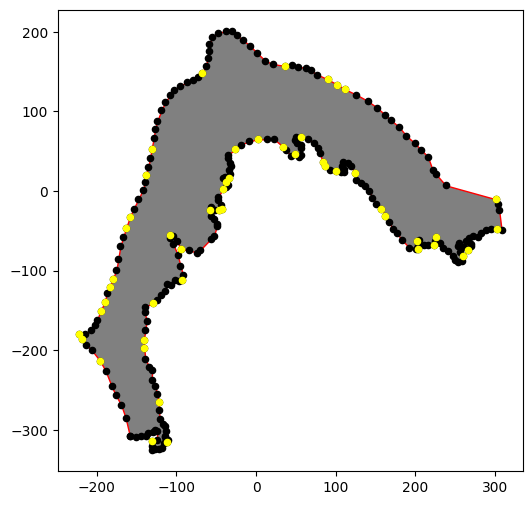

In [12]:
if not centroid_inside:
  # Get all vertices of location
  vertices = gp.get_all_vertices(location_aeqd)
  # Get candidate vertices
  candidates = gp.get_candidate_vertices(vertices)

gpp.plot_geopick(None, location_aeqd, None, None, None, vertices, candidates, None, None, None, None, None, None)

### Nearest point in location geometry

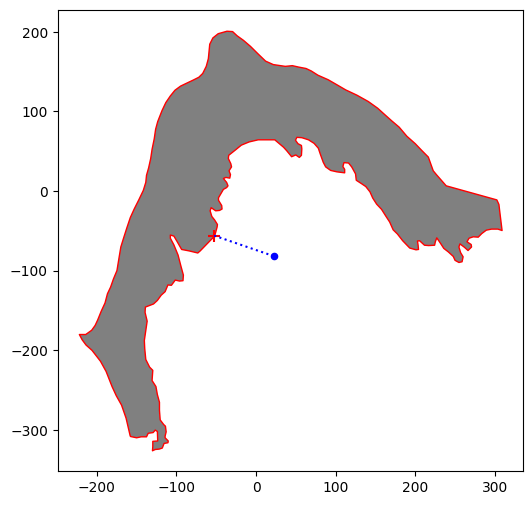

In [13]:
if not centroid_inside:
  # Calculate nearest point from centroid to location
  np = gp.get_nearest_point(centroid_aeqd, location_aeqd, proj_aeqd)

  # Plot
  coords_np = np.get_coordinates()
  coords_centroid_aeqd = centroid_aeqd.get_coordinates()
  np_segment = gpd.GeoSeries(
      [
          shapely.geometry.LineString([
            (coords_np['x'][0], coords_np['y'][0]), 
            (coords_centroid_aeqd['x'][0], coords_centroid_aeqd['y'][0])
            ]),
      ],
      crs=proj_aeqd
  )  

# Plot
gpp.plot_geopick(None, location_aeqd, centroid_aeqd, None, None, None, None, np, np_segment, None, None, None, None)

### Candidate points = geometry vertices sample + nearest point

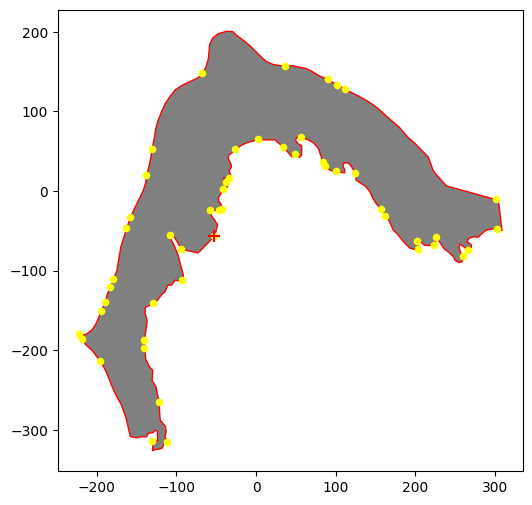

In [14]:
if not centroid_inside:
  # Add nearest point to candidate points
  candidates = pd.concat([candidates, np], ignore_index=True)
  candidates = candidates.reset_index(drop=True)

# Plot
gpp.plot_geopick(None, location_aeqd, None, None, None, None, candidates, np, None, None, None, None, None)

### First approximation to corrected center

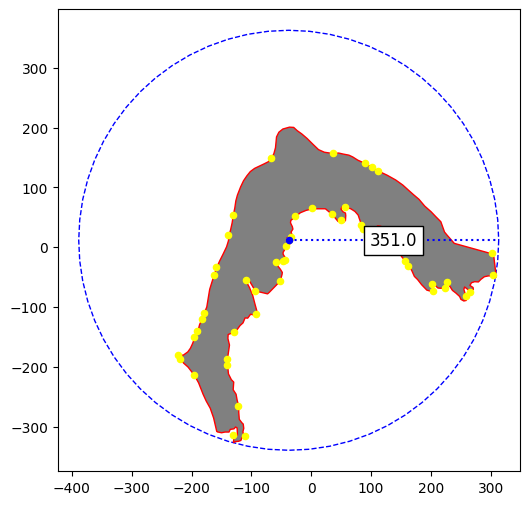

In [15]:
if not centroid_inside:
  # First approximation
  fa = gp.get_minimum_distance_candidate(candidates, vertices)
  centroid_fa = gpd.GeoSeries(fa[0])
  centroid_fa.crs = proj_aeqd
  uncertainty_fa = fa[1]
  sec_fa = gpd.GeoSeries(centroid_fa.buffer(uncertainty_fa))
  sec_fa.crs = proj_aeqd

# Plot
radius = gp.get_radius_line(sec_fa.centroid, sec_fa)
gpp.plot_geopick(sec_fa, location_aeqd, sec_fa.centroid, radius[0], uncertainty_fa, None, candidates, None, None, None, None, None, None)

### Second approximation to corrected center

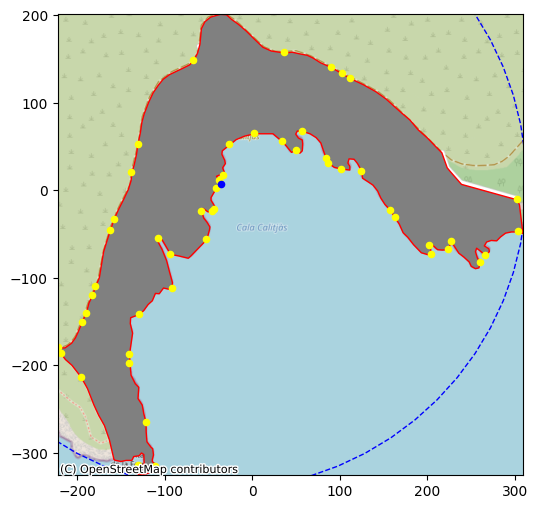

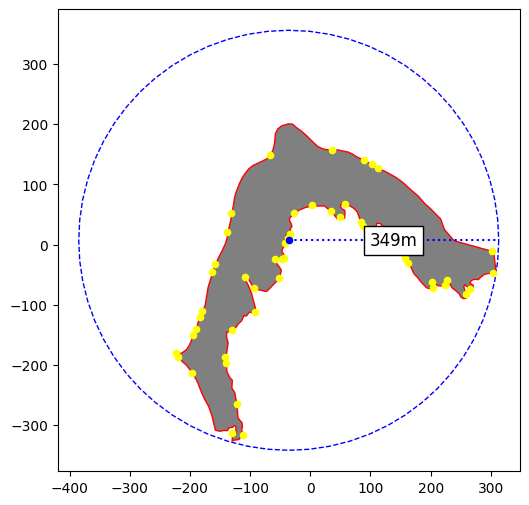

In [16]:
if not centroid_inside:
  # Second approximation
  np_centroid_fa = gp.get_nearest_n_vertices(vertices, centroid_fa, 10)
  sa = gp.get_minimum_distance_candidate(np_centroid_fa, vertices)
  centroid_sa = gpd.GeoSeries(sa[0])
  centroid_sa.crs = proj_aeqd
  uncertainty_sa = sa[1]
  sec_sa = gpd.GeoSeries(centroid_sa.buffer(uncertainty_sa))
  sec_sa.crs = proj_aeqd
  
  # Plot
  gpp.plot_geopick(sec_sa, location_aeqd, sec_sa.centroid, None, None, None, candidates, None, None, [-70, 180], [-80, 70], None, None) 
  radius = gp.get_radius_line(sec_sa.centroid, sec_sa)
  gpp.plot_geopick(sec_sa, location_aeqd, sec_sa.centroid, radius[0], radius[1], None, candidates, None, None, None, None, None, None)

### Selection of best center

In [17]:
# Compare uncertainty of first and second approximations
if not centroid_inside:
  if(uncertainty_sa < uncertainty_fa):
    centroid = sa[0]
    uncertainty = sa[1]
    sec = sec_sa
  else:
    centroid = fa[1]
    uncertainty = fa[1]
    sec = sec_fa
  
  centroid = gpd.GeoSeries(centroid)
  centroid.crs = proj_aeqd

### Final corrected center and associated uncertainty

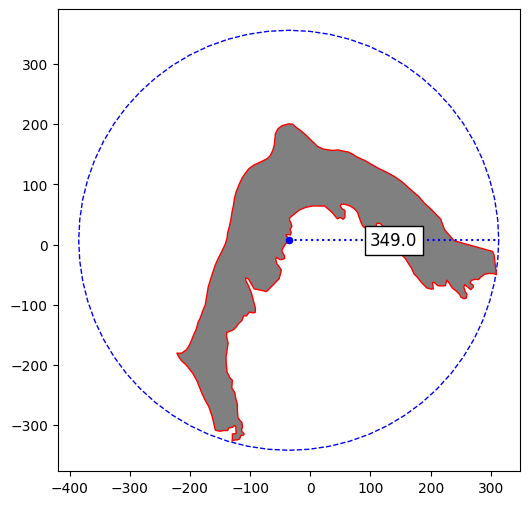

In [18]:
if not centroid_inside:
  # Plot
  p1 = [centroid.x, centroid.y]
  coords2 = sec.get_coordinates().iloc[0]
  p2 = [max(sec.get_coordinates()["x"]), coords2["y"]]
  radius_line = gpd.GeoSeries(
      [
          shapely.geometry.LineString([(p1[0], p1[1]), (p2[0], p2[1])]),
      ],
      crs=proj_aeqd
  )
  # Plot
  centroid = gpd.GeoSeries(shapely.geometry.Point(p1))
  gpp.plot_geopick(sec, location_aeqd, centroid, radius_line, uncertainty, None, None, None, None, None, None, None, None)

## Calculation of spatial fit

In [19]:
if not centroid_inside:
  # Calculate spatial fit
  spatial_fit = gp.get_spatial_fit(location_aeqd, uncertainty)

## Reprojection to WGS84

In [20]:
# Project back to WGS84 projection
if not centroid_inside:
  centroid = gpd.GeoSeries(shapely.geometry.Point(centroid[0]))
  centroid.crs = proj_aeqd
  centroid = centroid.to_crs(4326)
  sec = sec.to_crs(4326)


## Location's georeference

In [21]:
georeference_string = gp.print_georeference((centroid, uncertainty, spatial_fit, True))
display(Markdown(georeference_string))

**LOCATION'S CENTROID:** <br><br>    Latitude, Longitude: 42.250492, 3.238778<br>    Uncertainty: 349m<br>    Spatial fit: True

In [22]:
# Map
latitude = round(centroid.get_coordinates()["y"][0], 7)
longitude = round(centroid.get_coordinates()["x"][0], 7)
fcol = lambda x: {
    'fillColor': "blue" if x["properties"]["is_marine"] == "True" else "green",
    'color': "blue" if x["properties"]["is_marine"] == "True" else "green"
}

m = folium.Map(location = [latitude, longitude], zoom_start = 16)
folium.GeoJson(sec).add_to(m)
folium.GeoJson(location_wgs84).add_to(m)
folium.GeoJson(centroid).add_to(m)
m